# Analysis by using graph tools

The purpose to this analysis is to find out which headline exists as a center in network made from headlines and certain keywords that we have found from TF-IDF analysis.

We divide cleaned dataset by about 5-year timespan.(we used headlines set from 2016 to 2019, from 2011 to 2015 and from 2006 to 2010.) Afterward, using a fixed frequent keyword for each dataset (we used TF-IDF result), we created graphs for each keyword.

Finally, we got degree distributions, betweeness/degree/eigenvector centrality.



In our project, large calculation is needed. Therefore we used caluculation resource from Google.

In [0]:
# Mount to Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
from fa2 import ForceAtlas2
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import datetime
from google.colab import files
import io

# read dataset
df=pd.read_csv('/content/drive/My Drive/02805data/TheGuardianData.csv')#,encoding="utf-8")

# divide data every three years
df_1619=df[df['year']>2015]
df_1115=df[(df['year']>2010) & (df['year']<2016)]
df_0610=df[(df['year']>2005)&(df['year']<2011)]




We extracted a keyword for each time span using result from TF-IDF.
We choce words that appeared many times in top highest 50 words of TF-IDF list.
To calculate this, we used dataset as below. (pair of a word and score of TF-IDF.)

In [0]:
import pandas as pd
# dataset from 2016 to 2019
df=pd.read_pickle('/content/drive/My Drive/02805data/tfidf2006_2010.pkl')
df.head()

,tfidf
0,"[(oct, 0.002005818757041745), (newsdesk, 0.001..."
1,"[(feb, 0.0017187332834343587), (howlett, 0.000..."
2,"[(tomasky, 0.0021519109816148236), (newsbucket..."
3,"[(swine, 0.0014609472096455151), (tomasky, 0.0..."
4,"[(wikileaks, 0.0044579864245473605), (tomasky,..."


In [0]:
# find out a keyword(an important word) from each dataset

def keyword_ranking(filename):

  import nltk
  import pandas as pd
  df=pd.read_pickle(filename)
  k_words=[]
  for i in range(len(df)):
    # add top 50 words that is highest TF-IDF value in each year (if filename=tfidf2006_2010.pkl, we get top 50words from 2006,2007 and etc.) to k_words
    k_words.extend(list(dict(list(df.iloc[i])[0]).keys())[:50])
  # return pairs (word, how many times the word appears in top 50 for whole years). e.g. ('allardyce', 3) means 'allardyce' is in top50 three years. 
  return sorted(dict(nltk.FreqDist(k_words)).items(),key=lambda x:-x[1])

p=keyword_ranking('/content/drive/My Drive/02805data/tfidf2006_2010.pkl')
q=keyword_ranking('/content/drive/My Drive/02805data/tfidf2011_2015.pkl')
r=keyword_ranking('/content/drive/My Drive/02805data/tfidf2016_2019.pkl')

metoo is chosen from 2016-2019 as a keyword. We ignored writers name and "common" words like 'sportwatch'.

In [0]:
r[:15] # metoo is chosen from 2016-2019 as a keyword. (we ignored )

[('allardyce', 3),
 ('grenfell', 3),
 ('sportwatch', 3),
 ('meera', 3),
 ('weatherwatch', 3),
 ('metoo', 3),
 ('wrack', 3),
 ('ardern', 3),
 ('barden', 2),
 ('loughlin', 2),
 ('valenti', 2),
 ('slaven', 2),
 ('thrasher', 2),
 ('matteo', 2),
 ('nuccitelli', 2)]

snowden is chosen from 2011-2015 as a keyword.

In [0]:
q[:15] 

[('rowson', 4),
 ('boas', 3),
 ('bagchi', 3),
 ('walshe', 3),
 ('fearnley', 3),
 ('whittingstall', 3),
 ('sadhbh', 3),
 ('voucher', 3),
 ('huhne', 3),
 ('viewfinder', 3),
 ('nsa', 3),
 ('sudoku', 3),
 ('snowden', 3),
 ('recap', 3),
 ('farage', 3)]

twitter is chosen from 2006-2010 as a keyword

In [0]:
p[:15] 

[('newsbytes', 4),
 ('newsbucket', 4),
 ('henley', 3),
 ('feb', 3),
 ('soundings', 3),
 ('garton', 3),
 ('tims', 3),
 ('howlett', 3),
 ('tomasky', 3),
 ('katine', 3),
 ('fabio', 3),
 ('twitter', 3),
 ('oct', 2),
 ('newsdesk', 2),
 ('nov', 2)]

We have selected key words already, then we prepared functions to create graphs.
Nodes are headlines. The ways to select nodes is simply whether a headline contains this keyword or not. On the other hand, we built a edge if both nodes has common word. Moreover, edges are weighted in such a way:

- $(\mbox{weight}) = (\mbox{number of common words}) - \arctan(\mbox{time distance})\frac{2}{\pi}+\delta_{\mbox{subgenre1},\mbox{subgenre2}}$

This means the weight is basically number of common words, but if time distance is far between these headlines make weight decrease. In addition, only if both subgenres are same, weight is added by 1 otherwise not.

We have thousands of nodes,thus we have to calculate $\frac{N(N-1)}{2}$ ($N$ is number of nodes.) times.

Therefore, we  used multi processing. (pool function)

In [0]:
from tqdm import tqdm
import dask.dataframe as dd
from dask.multiprocessing import get
import functools
import math

##########################################################################################################################################
# convert token list into set (preparation of dataframe) that is needed to calculate how many common words are.

# preparation for multithread
# headlines in dataframe is converted from string into set
def set_creater(leng,data_head_i,counter):
    print(counter,end='')
    #print("\r %.3f percent"%(float(counter)/leng*100.),end='')
    return set(data_head_i.replace("'",'').replace(' ','')[1:-1].split(','))

# wrapper
def wrapper_set_creater(args):
  return set_creater(*args)

# main function
def token_to_set(data):
  from multiprocessing import Pool 

  if __name__ == "__main__":
    data_b=data.copy()
    leng=len(data)
    data_head=data_b['HeadlineToken']
   
    couter=0
        
    data_head_list=[]

    print("Percel")
    percel=[[leng,data_head.iloc[i],i] for i in range(leng)]
    print("DONE")
    
    p = Pool(processes=24)
    edge_list=p.map(wrapper_set_creater, percel)
    print("DONE")

    data_b['HeadlineToken']=edge_list
    return data_b
    print('DONE')

#######################################################################################################################

# Extract headlines related to a certain key word
def search_hl_keyword(data,word):
    if(len(word)>0):
        table=data.iloc[[i for i in range(len(data)) if word in list(data['HeadlineToken'].iloc[i])]].copy()
        return table
    else:
        print("ERROR")


########################################################################################################################

# make a graph
# preparation for multithread
# calculate weight of edges 
def add_edge(i,j,data):
    #printf((i,j))
    dicx=dict(data.iloc[i])
    dicy=dict(data.iloc[j])
    
    x=dicx['Unnamed: 0']
    y=dicy['Unnamed: 0']
    timex=datetime.datetime.strptime(dicx['Date'], '%Y-%m-%d')
    timey=datetime.datetime.strptime(dicy['Date'], '%Y-%m-%d')
    time_dist=float(abs(timex-timey).days)
    weight=len(dicx["HeadlineToken"].intersection(dicy["HeadlineToken"]))
    if(dicx["SubGenre"]==dicy["SubGenre"]):
        weight+=1.
    weight=float(weight)
    weight-=math.atan(time_dist)*2/math.pi
    
    
    
    return (x,y,weight)

# wrapper
def wrapper_add_edge(args,data):
  return add_edge(*args,data)

# main function
def df_to_graph(data):
  from multiprocessing import Pool
  if __name__ == "__main__":
    

    G=nx.Graph()


    for i in range(len(data)):
        dic=dict(data.iloc[i])
        G.add_node(dic['Unnamed: 0'])
        print("\r %.3f percent"%(float(i)/len(data)*100.),end='')
    print('NODE DONE')
    print(len(G.nodes))

    counter=0
    i_j=[]
    leng=len(data)
    for i in range(leng-1):
      for j in range(i+1,leng):
        i_j.append([i,j])

    print("percel DONE")
    edge_list=[]
    p = Pool(processes=24)
    edge_list=p.map(functools.partial(wrapper_add_edge, data=data), i_j)
    #result = list(tqdm(edge_list, total=leng*(leng-1)/2))
    print("EDGE DONE")
    print(len(edge_list))
    G.add_weighted_edges_from(edge_list)# if tp[2]!=0)
    print("ADDED")
    return G

########################################################################################################################

# above functions are combined in below function
def create_graph(data,word=''):
    data_2=token_to_set(data).copy()
    if(word==''):
        table=data_2.copy()
    else:
        table=search_hl_keyword(data_2,word)
    G=df_to_graph(table)
    return G


We have alredy made functions needed to make graphs, thus we can excute these for our dataset.

In [0]:
# create graphs from keywords
G_1619=create_graph(df_1619,"metoo")
G_1115=create_graph(df_1115,"snowden")
G_0610=create_graph(df_0610,"twitter")

Percel
DONE
DONE
 99.567 percentNODE DONE
231
percel DONE
EDGE DONE
26565
ADDED
Percel
DONE
DONE
 99.717 percentNODE DONE
353
percel DONE
EDGE DONE
62128
ADDED
Percel
DONE
DONE
 99.756 percentNODE DONE
410
percel DONE
EDGE DONE
83845
ADDED


From the graph, we got transitivity of frequency for each word.
As below,  "me too" is most frequent in 2018, "snowden" appeared suddenly in 2013 and frequency got decrease, and "twitter" get popular gradually from 2016 and suddenly get so frequent around 2009.

FreqDist({2007: 6, 2008: 30, 2009: 197, 2010: 177})

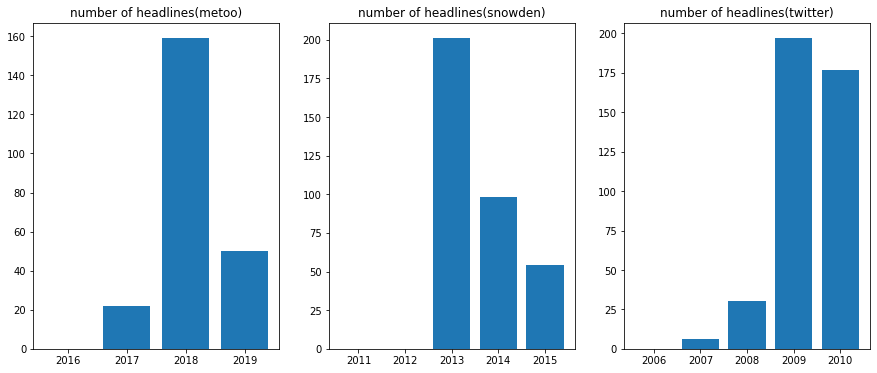

In [0]:
# barplot of how many times these keywords showed up in headlines.

import nltk
plt.figure(figsize=(15, 6))
plt.subplot(1,3,1)
plt.bar(range(2016,2020),[nltk.FreqDist(list(df.iloc[list(G_1619.nodes())]['year']))[i] for i in range(2016,2020)])
plt.title('number of headlines(metoo)')

plt.subplot(1,3,2)
plt.bar(range(2011,2016),[nltk.FreqDist(list(df.iloc[list(G_1115.nodes())]['year']))[i] for i in range(2011,2016)])
plt.title('number of headlines(snowden)')

plt.subplot(1,3,3)
plt.bar(range(2006,2011),[nltk.FreqDist(list(df.iloc[list(G_0610.nodes())]['year']))[i] for i in range(2006,2011)])
plt.title('number of headlines(twitter)')





Then we plot graphs using force atlas2.

In [0]:
# plotting graphs by forceatlas2, node size is eigenvalue, betweenness or degree centrality

# make subgebre dictionary to convert subgenres into color tuples
import nltk
sgenre_dict=dict([(sg,num)for num,sg in list(enumerate(list(df['SubGenre'].unique())))])
sorted_sg_lst=sorted((nltk.FreqDist(df['SubGenre'])).items(),key=lambda x:-x[1])

def fa2_draw(graph):

  import matplotlib.cm as cm

  # force atlas
  forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=True,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=1.0,

                          # Performance
                          jitterTolerance=1.0,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=1.2,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning

                          scalingRatio=2.0,
                          strongGravityMode=False,
                          gravity=30.0,

                          # Log
                          verbose=True)

  # draw wikipedia network using node degree

  plt.figure(figsize=(25, 8))
  positions = forceatlas2.forceatlas2_networkx_layout(graph, pos=None, iterations=2000)
  
  col=[cm.hsv(sgenre_dict[df['SubGenre'][int(i)]]/60.) for i in list(graph.nodes())]
  
  plt.subplot(1,3,1)
  nx.draw_networkx_nodes(graph, positions,with_labels=False, node_color=col, alpha=0.5,node_size=[d/6 for n,d in graph.degree(weight='weight')])
  nx.draw_networkx_edges(graph, positions, edge_color="green", alpha=0.005)
  plt.title("degree")

  plt.subplot(1,3,2)
  nx.draw_networkx_nodes(graph, positions,with_labels=False, node_color=col, alpha=0.5,node_size=[d*4000 for n,d in nx.eigenvector_centrality(graph,weight='weight').items()])
  nx.draw_networkx_edges(graph, positions, edge_color="green", alpha=0.005)
  plt.title("eigenvalue")

  plt.subplot(1,3,3)
  nx.draw_networkx_nodes(graph, positions,with_labels=False, node_color=col, alpha=0.5,node_size=[d*5000 for n,d in nx.betweenness_centrality(graph,weight='weight').items()])
  nx.draw_networkx_edges(graph, positions, edge_color="green", alpha=0.01)
  plt.title("betweenness")

  #draw edges
  
  plt.axis('off')
  plt.show()



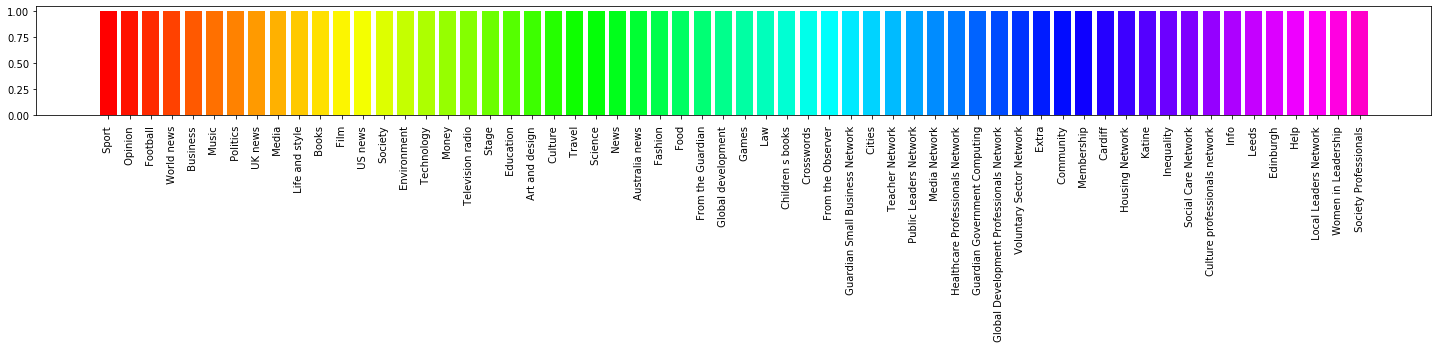

In [0]:
# to show color of each subgenre in next graph 
import matplotlib.cm as cm

sg_col=[(sg,cm.hsv(sgenre_dict[sg[0]]/67.)) for sg in sgenre_dict.items()]
plt.figure(figsize=(25, 2))
ax = plt.subplot()
plt.setp(ax.get_xticklabels(), rotation=90)
plt.bar([sg[0] for sg in sorted_sg_lst[:60]],height=[1 for i in range(60)],color=[c[1] for c in sg_col[:60]])
plt.show()

Below graphs are "me too" graph(2016-2019), "snowden" graph(2011-2015) and "twitter" graph(2006-2010) from the top.
Node sizes are degree, eigenvector and betweeness centrality values and node colors depends on subcategory of each node.

100%|██████████| 2000/2000 [00:02<00:00, 676.24it/s]


BarnesHut Approximation  took  0.56  seconds
Repulsion forces  took  1.15  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.97  seconds
AdjustSpeedAndApplyForces step  took  0.10  seconds


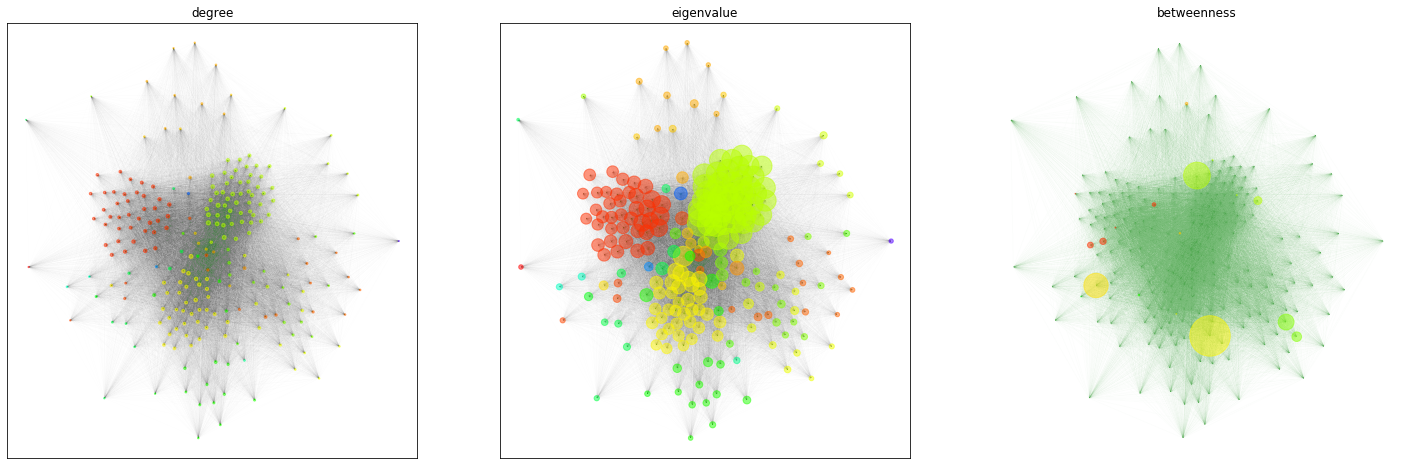

100%|██████████| 2000/2000 [00:06<00:00, 298.55it/s]


BarnesHut Approximation  took  1.32  seconds
Repulsion forces  took  2.67  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  2.27  seconds
AdjustSpeedAndApplyForces step  took  0.15  seconds


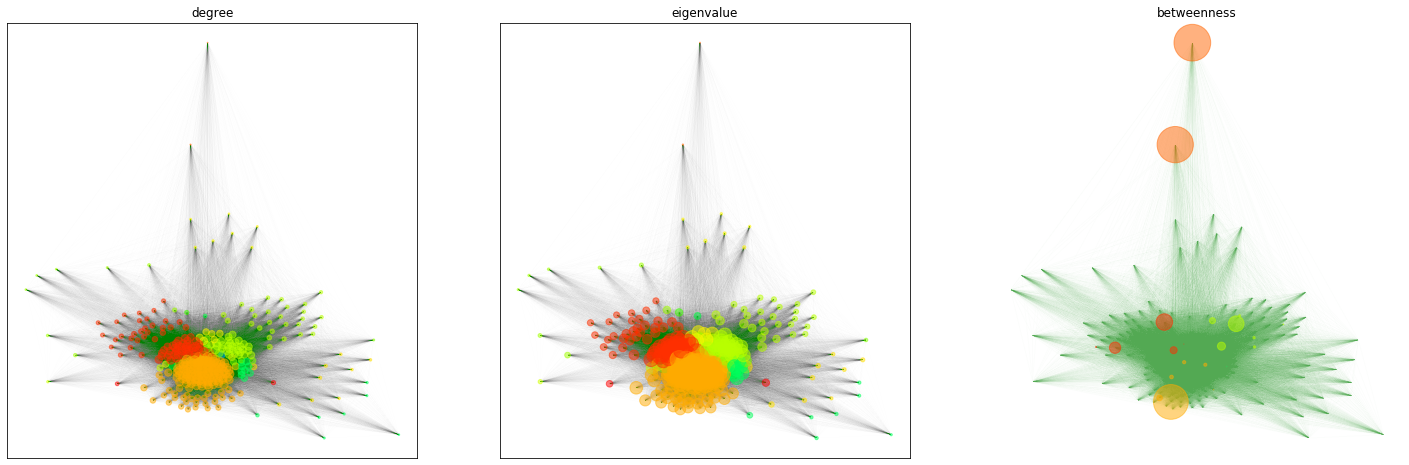

100%|██████████| 2000/2000 [00:07<00:00, 257.31it/s]


BarnesHut Approximation  took  1.66  seconds
Repulsion forces  took  2.56  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  3.04  seconds
AdjustSpeedAndApplyForces step  took  0.18  seconds


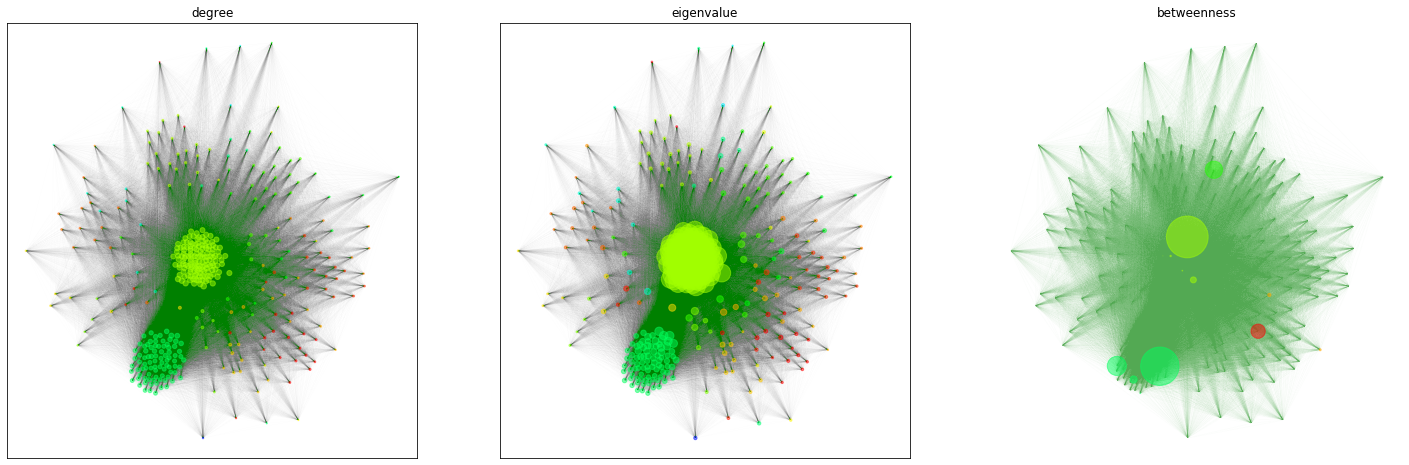

In [0]:
# show graphs
fa2_draw(G_1619)
fa2_draw(G_1115)
fa2_draw(G_0610)


For "me too" graph, main categories are Opinion(red), US news(yellow) and Society(yellow green).

For "snowden" graph, main categories are World news(orange red), Media(orange) and Society(yellow green).

For "twitter" graph, main categories are Technology(dark yellow green) and Society(yellow green).

Below graphs show degree distribution of 2006-2010,2011-2015 and 2016-2019 graph from the left.

In each graph, we got some "peaks", for instance, in the left graph there are three peaks.
The number of peaks meet the number of large cluster in above graphs. This is because edge weight is added by 1 when both headline subgenres are same.  

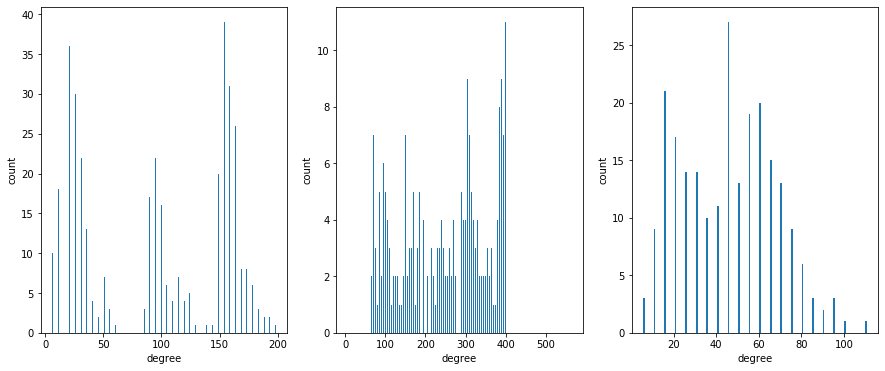

In [0]:
# show degree distribution(weighted)
def draw_distribution(ls):
    import numpy as np
    histo_data=np.histogram(ls,bins=int(max(ls)/5))
    X = []
    for i in range(1, len(histo_data[1])):
        X.append((histo_data[1][i-1]+histo_data[1][i])/2)
    plt.bar(X,histo_data[0])
    plt.xlabel("degree")
    plt.ylabel("count")

plt.figure(figsize=(15, 6))

plt.subplot(1,3,1)
draw_distribution(list(dict(G_0610.degree(weight='weight')).values()))
plt.subplot(1,3,2)
draw_distribution(list(dict(G_1115.degree(weight='weight')).values()))
plt.subplot(1,3,3)
draw_distribution(list(dict(G_1619.degree(weight='weight')).values()))


Finally, we got larger size nodes in above graphs, that is top 5 centers in the standpoints of degree, betweeness and eigenvector centrality.

In [18]:
# show top 5 central nodes shown as headline indices (eigen,betweenness and degree)

G_ls=[G_0610,G_1115,G_1619]
hl_top5={}
G_name={0:'twitter',1:'snowden',2:'metoo'}
for i in range(3):
  d={}
  print("keyword: ",end='')
  print(G_name[i])
  # caluculation of eigenvector centrality
  eig_cent=sorted(nx.eigenvector_centrality(G_ls[i],weight='weight').items(),key=lambda x:-x[1])[:5]
  eig_hl=[num for num,val in eig_cent]
  d['eig']=(eig_hl)

  print("eig top5: ",end='')
  print(eig_cent)

  # caluculation of between centrality

  bet_cent=sorted(nx.betweenness_centrality(G_ls[i],weight='weight').items(),key=lambda x:-x[1])[:5]
  print("bet top5: ",end='')
  print(bet_cent)
  bet_hl=[num for num,val in bet_cent]
  d['bet']=(bet_hl)

  deg_cent=sorted(dict(G_ls[i].degree(weight='weight')).items(),key=lambda x:-x[1])[:5]
  print("deg top5: ",end='')
  print(deg_cent)
  deg_hl=[num for num,val in deg_cent]
  d['deg']=(deg_hl)

  hl_top5[G_name[i]]=d

keyword: twitter
eig top5: [(698058, 0.09433241454121824), (720158, 0.0933639768248122), (735045, 0.09072673637958828), (678535, 0.0902465322445124), (690625, 0.08879409640180577)]
bet top5: [(892039, 0.3489500934848267), (854129, 0.2952142959873436), (624234, 0.07333764801764227), (624558, 0.060123927321539865), (813831, 0.04089361906131646)]
deg top5: [(698058, 200.47720627067773), (678535, 194.96308319615963), (720158, 191.56970600015347), (690625, 189.66358201586402), (735045, 187.587350535708)]
keyword: snowden
eig top5: [(378904, 0.09518695422483292), (454009, 0.08951642843550084), (451502, 0.08852591676937643), (332573, 0.08838825172341629), (451722, 0.08827562863533049)]
bet top5: [(280853, 0.2698485927652594), (280896, 0.2635516489683156), (276426, 0.24211667961667963), (453998, 0.05503755503755504), (453989, 0.049663299663299666)]
deg top5: [(378904, 565.9800294797589), (454009, 539.4142593454467), (417835, 532.6190857400783), (451722, 529.9802483387153), (332573, 526.3595069

Above results only showed pairs of index of headline and centrality value. From this we coverted them into headlines.

In these results, betweenness centrality tend to contain something tha is not related to our keyword essentially. For example, results for "snowden" contains another "snowden". (she is musician!)
That is because betweeness centrality tend to be larger when the node is between relatively large cluster by definition, that is, the node tend to connect various subgenre nodes.

In the other hand, results from degree centrality and eigenvector centrality are almost same. That is from the way to make a graph, that is, since nodes in same subcategory are connected, the largest degree nodes tend to be in the largest cluster.(dominant cluster in a graph) In short, size of subgenre is main factor of centrality.

It is plausible that by manipulating parameters in creating edge function, we get another results.

Next, we are going to write about headlines themselves.



In [47]:
# show top 5 central nodes shown as headline (eigen,betweenness and degree)

df_rough=pd.read_pickle('/content/drive/My Drive/02805data/dfGuardian.pkl')

cent_type={0:'bet',1:'deg',2:'eig'}
for i in range(3):
  print(G_name[i],end='')
  print(" : ")
  for j in range(3):
    print(cent_type[j])
    for k in range(5):
      print((list(df['Date'][hl_top5[G_name[i]][cent_type[j]]])[k],list(df['SubGenre'][hl_top5[G_name[i]][cent_type[j]]])[k]),end=' ')
      print(list(df_rough['HeadlineToken'][hl_top5[G_name[i]][cent_type[j]]])[k] )
    print()
  print()

twitter : 
bet
('2007-03-11', ' Technology ')  Twitter crowd goes bananas at SXSW 
('2007-09-25', ' Media ')  Do you use Twitter for reporting 
('2010-12-29', ' Media ')  Forecast for 2011 Mark Rock on Twitter s IPO and Arrington leaving TechCrunch 
('2010-12-27', ' Life and style ')  What happened next The student followed by Kanye West on Twitter 
('2008-04-17', ' Politics ')  Highlights of Gordon Brown s US visit as posted by his aides on Twitter 

deg
('2009-12-01', ' Technology ')  Twitter Facebook and Google turn red for World Aids Day 
('2010-03-16', ' Technology ')  Traffic to Twitter and Facebook fell in February in US says Compete 
('2009-08-06', ' Technology ')  Twitter Facebook Google and LiveJournal under attack 
('2010-01-12', ' Technology ')  How Facebook and Twitter could save us from dreaded email overload 
('2009-05-21', ' Technology ')  A good day for phishing on Facebook and Twitter 

eig
('2009-12-01', ' Technology ')  Twitter Facebook and Google turn red for World